# 03 - EU区订单与订阅分析

分析OSAIO和Nooie两个品牌的订单、订阅、收入数据。

**数据范围**: 2025-01-01 至今  
**分析维度**: 订单趋势、订阅类型、试用转化、收入分析、币种分布、多设备订阅、云服务时长、设备订阅覆盖率

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import calendar
import sqlite3
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# 绘图配置
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

# Pandas 显示配置
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:,.2f}'.format)

# 时间常量
TODAY = pd.Timestamp.now().normalize()
YESTERDAY = TODAY - pd.Timedelta(days=1)
CURRENT_MONTH = TODAY.to_period('M')
ELAPSED_DAYS = YESTERDAY.day

print(f'分析时间: {datetime.now().strftime("%Y-%m-%d %H:%M")}')
print(f'当前月已过天数: {ELAPSED_DAYS}')

分析时间: 2026-02-16 17:02
当前月已过天数: 15


## 1. 数据加载

In [2]:
# 连接本地 SQLite (由 scripts/sync_order_data.py 生成)
db = sqlite3.connect('../data/order_data.db')
print(f'已连接本地 SQLite')

# 验证数据
for table in ['orders', 'subscribe', 'set_meal', 'order_amount_info', 'cloud_info']:
    cnt = pd.read_sql(f"SELECT brand, COUNT(*) as cnt FROM {table} GROUP BY brand", db)
    print(f"  {table}: {dict(zip(cnt['brand'], cnt['cnt']))}")

已连接本地 SQLite
  orders: {'Nooie': 68431, 'OSAIO': 249974}
  subscribe: {'Nooie': 20293, 'OSAIO': 68090}
  set_meal: {'Nooie': 241, 'OSAIO': 289}
  order_amount_info: {'Nooie': 68191, 'OSAIO': 248220}
  cloud_info: {'Nooie': 68427, 'OSAIO': 248919}


In [3]:
# 从本地 SQLite 加载数据
print('加载 orders...')
df_all = pd.read_sql("SELECT * FROM orders", db)
print(f'  orders: {len(df_all):,} rows')

print('加载 subscribe...')
df_sub = pd.read_sql("SELECT * FROM subscribe", db)
print(f'  subscribe: {len(df_sub):,} rows')

print('加载 set_meal...')
df_meal = pd.read_sql("SELECT * FROM set_meal", db)
print(f'  set_meal: {len(df_meal):,} rows')

print('加载 order_amount_info...')
df_amount = pd.read_sql("SELECT * FROM order_amount_info", db)
print(f'  order_amount_info: {len(df_amount):,} rows')

print('加载 cloud_info...')
df_cloud_all = pd.read_sql("SELECT * FROM cloud_info", db)
print(f'  cloud_info: {len(df_cloud_all):,} rows')

print('加载 device_stats...')
df_device_stats = pd.read_sql("SELECT * FROM device_stats", db)
device_counts = dict(zip(df_device_stats['brand'], df_device_stats['total_devices'].astype(int)))
print(f'  device_stats: {device_counts}')

print('\n数据加载完成')

加载 orders...


  orders: 318,405 rows
加载 subscribe...
  subscribe: 88,383 rows
加载 set_meal...
  set_meal: 530 rows
加载 order_amount_info...


  order_amount_info: 316,411 rows
加载 cloud_info...


  cloud_info: 317,346 rows
加载 device_stats...
  device_stats: {'OSAIO': 197193, 'Nooie': 30965}

数据加载完成


In [4]:
# 合并关联表到 orders
# JOIN subscribe
df_all = df_all.merge(
    df_sub[['subscribe_id', 'brand', 'cycles_unit', 'cycles_time', 
            'sub_status', 'sub_create_time', 'sub_cancel_time', 'support_dev_num']],
    on=['subscribe_id', 'brand'], how='left', suffixes=('', '_sub')
)

# JOIN set_meal
df_all = df_all.merge(
    df_meal[['code', 'brand', 'name', 'time_unit', 'time']].rename(
        columns={'code': 'product_id', 'name': 'meal_name', 'time_unit': 'meal_time_unit', 'time': 'meal_time'}
    ),
    on=['product_id', 'brand'], how='left'
)

# JOIN order_amount_info
df_all = df_all.merge(
    df_amount[['order_int_id', 'brand', 'amount_cny', 'transaction_fee_cny', 'exchange_rate']],
    on=['order_int_id', 'brand'], how='left'
)

print(f'合并后: {len(df_all):,} rows, {len(df_all.columns)} columns')
print(f'列: {list(df_all.columns)}')

合并后: 637,671 rows, 26 columns
列: ['order_int_id', 'order_id', 'uid', 'subscribe_id', 'product_id', 'order_status', 'description', 'pay_time', 'amount', 'currency', 'transaction_fee', 'is_sub', 'pay_type', 'brand', 'cycles_unit', 'cycles_time', 'sub_status', 'sub_create_time', 'sub_cancel_time', 'support_dev_num', 'meal_name', 'meal_time_unit', 'meal_time', 'amount_cny', 'transaction_fee_cny', 'exchange_rate']


In [5]:
# 时间转换与预处理
df_all['order_date'] = pd.to_datetime(df_all['pay_time'], unit='s')
df_all['order_month'] = df_all['order_date'].dt.to_period('M')
df_all['order_week'] = df_all['order_date'].dt.to_period('W')

# 识别试用订单: description 包含 Trial 或 Promotion 或 Free
df_all['is_trial'] = df_all['description'].str.contains(
    r'(?i)trial|promotion|free', na=False
)
df_all['order_type'] = df_all['is_trial'].map({True: 'Trial/Free', False: 'Paid'})

# 订阅周期类型 (向量化: 优先用 meal_time_unit, 备用 cycles_unit)
unit_col = df_all['meal_time_unit'].fillna(df_all['cycles_unit']).fillna('').str.upper()
time_col = df_all['meal_time'].fillna(df_all['cycles_time']).fillna(0).astype(int)

conditions = [
    (unit_col == '') | (time_col == 0),
    (unit_col == 'DAY') & (time_col <= 30),
    (unit_col == 'DAY') & (time_col > 30),
    (unit_col == 'MONTH') & (time_col == 1),
    (unit_col == 'MONTH') & (time_col == 12),
    (unit_col == 'MONTH') & ~time_col.isin([1, 12]),
    (unit_col == 'YEAR') & (time_col == 1),
    (unit_col == 'YEAR') & (time_col != 1),
    (unit_col == 'WEEK'),
]
choices = [
    'Unknown',
    time_col.astype(str) + '-Day Trial',
    time_col.astype(str) + '-Day',
    'Monthly',
    'Annual',
    time_col.astype(str) + '-Month',
    'Annual',
    time_col.astype(str) + '-Year',
    time_col.astype(str) + '-Week',
]
df_all['sub_period'] = np.select(conditions, choices, default='Unknown')

# 净收入 (amount_cny - transaction_fee_cny)
df_all['net_revenue_cny'] = df_all['amount_cny'].fillna(0) - df_all['transaction_fee_cny'].fillna(0)

# cloud_info 时间转换
df_cloud_all['cloud_start_date'] = pd.to_datetime(df_cloud_all['cloud_start_time'], unit='s', errors='coerce')
df_cloud_all['cloud_end_date'] = pd.to_datetime(df_cloud_all['cloud_end_time'], unit='s', errors='coerce')
df_cloud_all['cloud_duration_days'] = (df_cloud_all['cloud_end_date'] - df_cloud_all['cloud_start_date']).dt.days

print('预处理完成')
print(f"\n试用订单占比: {df_all['is_trial'].mean()*100:.1f}%")
print(f"\n订阅周期分布:")
display(df_all['sub_period'].value_counts())

预处理完成

试用订单占比: 34.3%

订阅周期分布:


sub_period
Monthly         441462
30-Day Trial    145661
Annual           46623
1-Day Trial       2065
6-Month           1477
3-Month            184
3-Day Trial        184
2-Day Trial         12
7-Month              2
7-Day Trial          1
Name: count, dtype: int64

In [6]:
# 数据概览
print('=== 数据概览 ===')
print(f"总订单数: {len(df_all):,}")
print(f"时间范围: {df_all['order_date'].min().strftime('%Y-%m-%d')} ~ {df_all['order_date'].max().strftime('%Y-%m-%d')}")
print(f"\n品牌分布:")
display(df_all['brand'].value_counts())
print(f"\n订单类型:")
display(df_all.groupby('brand')['order_type'].value_counts().unstack(fill_value=0))

=== 数据概览 ===
总订单数: 637,671
时间范围: 2025-01-01 ~ 2026-02-17

品牌分布:


brand
OSAIO    566780
Nooie     70891
Name: count, dtype: int64


订单类型:


order_type,Paid,Trial/Free
brand,,
Nooie,65138,5753
OSAIO,353520,213260


## 2. 订单趋势分析

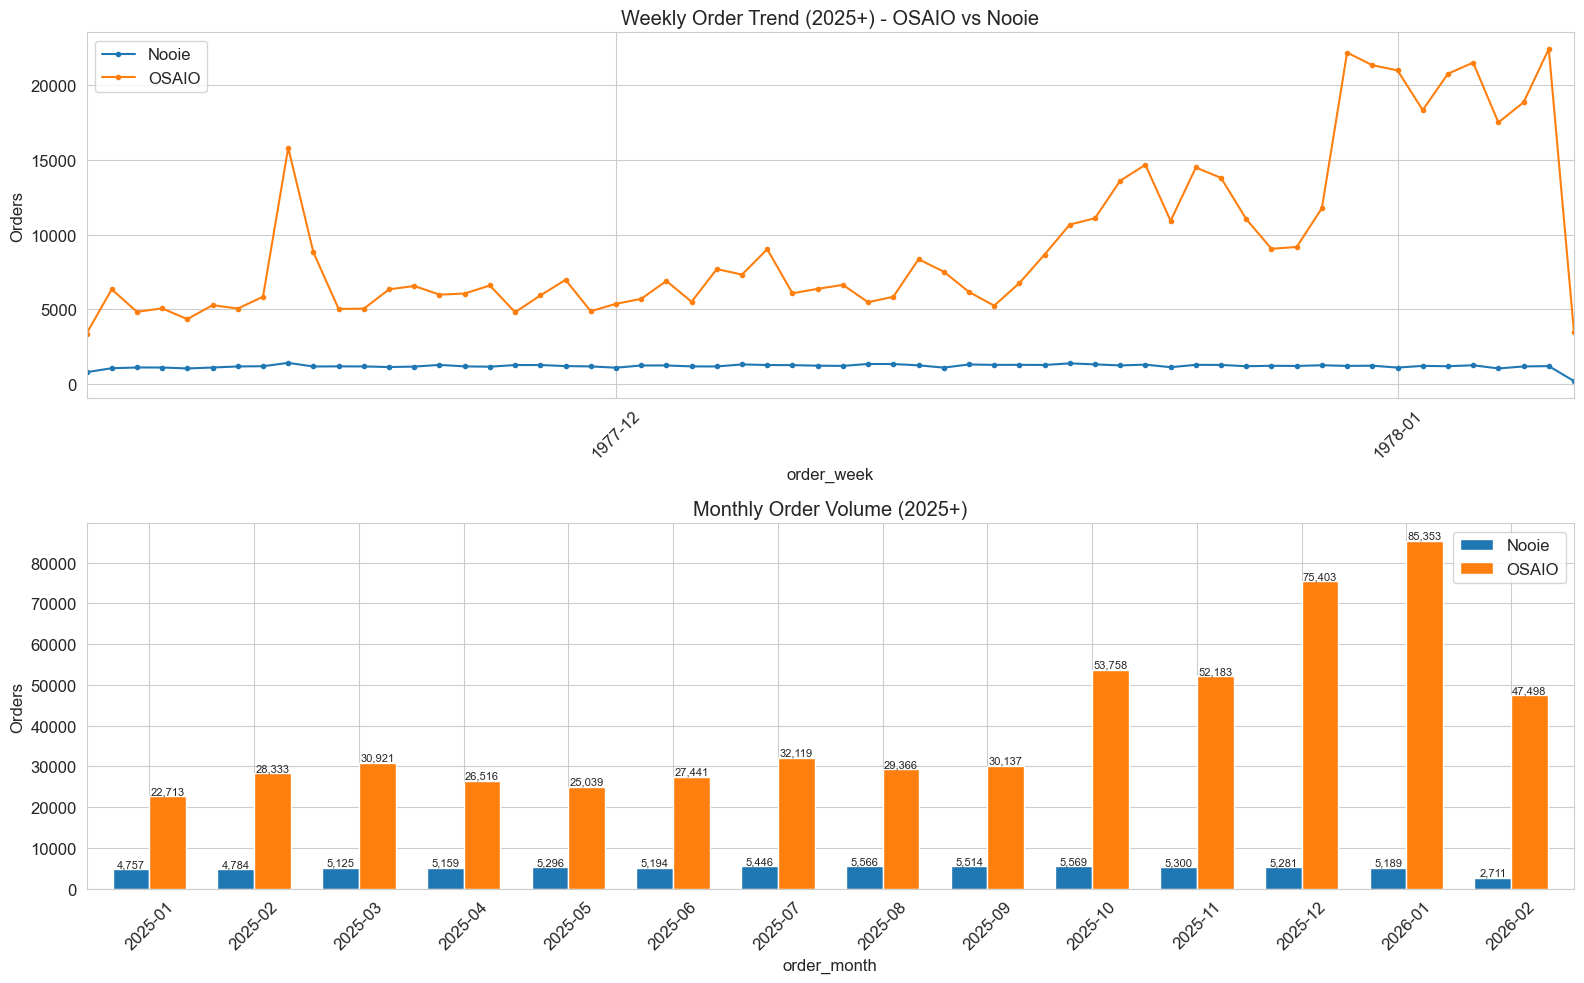

In [7]:
# 月度订单量
monthly_orders = df_all.groupby(['order_month', 'brand']).size().unstack(fill_value=0)
monthly_orders.index = monthly_orders.index.to_timestamp()

# 周度订单量
weekly_orders = df_all.groupby(['order_week', 'brand']).size().unstack(fill_value=0)
weekly_orders.index = weekly_orders.index.to_timestamp()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 周度趋势
weekly_orders.plot(ax=axes[0], marker='o', markersize=3, linewidth=1.5)
axes[0].set_title('Weekly Order Trend (2025+) - OSAIO vs Nooie')
axes[0].set_ylabel('Orders')
axes[0].xaxis.set_major_locator(mdates.MonthLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# 月度趋势 (含累积)
monthly_orders.plot(kind='bar', ax=axes[1], width=0.7)
axes[1].set_title('Monthly Order Volume (2025+)')
axes[1].set_ylabel('Orders')
axes[1].set_xticklabels([d.strftime('%Y-%m') for d in monthly_orders.index], rotation=45)
axes[1].legend()

# 标注数值
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='{:,.0f}', fontsize=8, rotation=0)

plt.tight_layout()
plt.savefig('../reports/order_trend.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# 月度日均订单量与增长率
for brand in ['OSAIO', 'Nooie']:
    brand_df = df_all[df_all['brand'] == brand]
    brand_monthly = brand_df.groupby('order_month').size()
    
    daily_avg = pd.DataFrame({'total': brand_monthly})
    daily_avg['days'] = daily_avg.index.map(
        lambda p: ELAPSED_DAYS if p == CURRENT_MONTH
        else calendar.monthrange(p.year, p.month)[1]
    )
    daily_avg['daily_avg'] = (daily_avg['total'] / daily_avg['days']).round(1)
    daily_avg['growth_%'] = (daily_avg['daily_avg'].pct_change() * 100).round(2)
    
    print(f'\n=== {brand} 月度日均订单量 ===')
    display(daily_avg)


=== OSAIO 月度日均订单量 ===


,total,days,daily_avg,growth_%
order_month,,,,
2025-01,22713,31,732.70,NaN
2025-02,28333,28,"1,011.90",38.11
2025-03,30921,31,997.50,-1.42
2025-04,26516,30,883.90,-11.39
2025-05,25039,31,807.70,-8.62
2025-06,27441,30,914.70,13.25
2025-07,32119,31,"1,036.10",13.27
2025-08,29366,31,947.30,-8.57
2025-09,30137,30,"1,004.60",6.05



=== Nooie 月度日均订单量 ===


,total,days,daily_avg,growth_%
order_month,,,,
2025-01,4757,31,153.50,NaN
2025-02,4784,28,170.90,11.34
2025-03,5125,31,165.30,-3.28
2025-04,5159,30,172.00,4.05
2025-05,5296,31,170.80,-0.70
2025-06,5194,30,173.10,1.35
2025-07,5446,31,175.70,1.50
2025-08,5566,31,179.50,2.16
2025-09,5514,30,183.80,2.40


## 3. 订阅类型分布

=== 订阅周期分布 ===


sub_period,1-Day Trial,2-Day Trial,3-Day Trial,3-Month,30-Day Trial,6-Month,7-Day Trial,7-Month,Annual,Monthly
brand,,,,,,,,,,
Nooie,31,9,0,0,361,0,1,2,4750,65737
OSAIO,2034,3,184,184,145300,1477,0,0,41873,375725


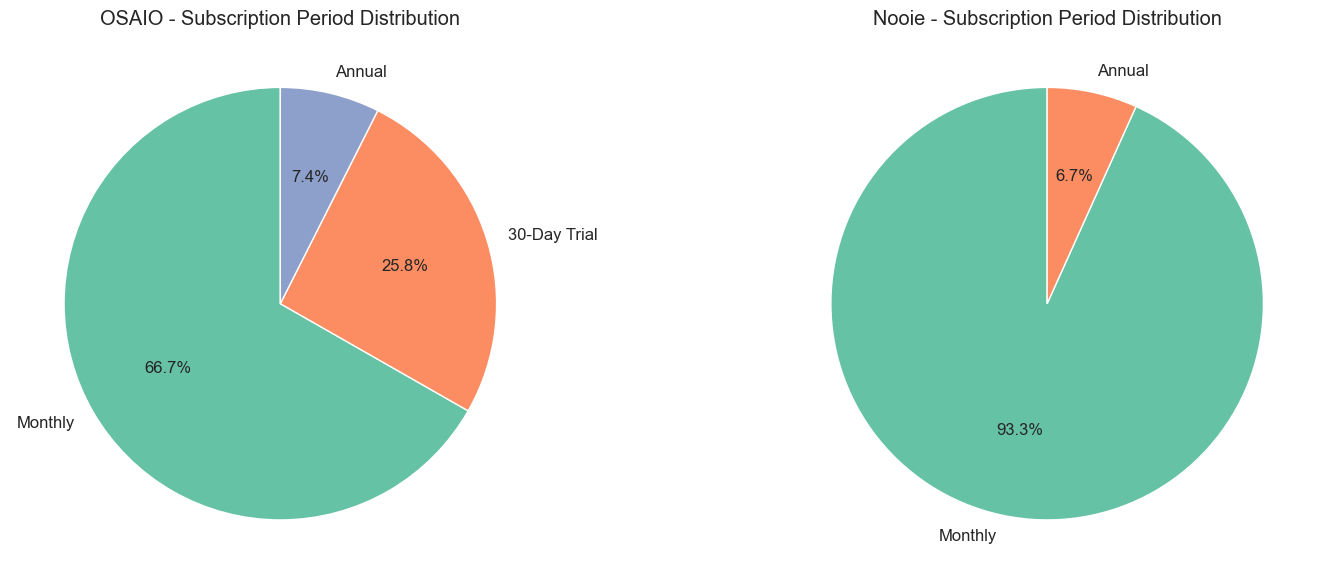

In [9]:
# 订阅周期分布 - 按品牌
sub_period_dist = df_all.groupby(['brand', 'sub_period']).size().unstack(fill_value=0)
print('=== 订阅周期分布 ===')
display(sub_period_dist)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, brand in enumerate(['OSAIO', 'Nooie']):
    brand_df = df_all[df_all['brand'] == brand]
    period_counts = brand_df['sub_period'].value_counts()
    
    # 过滤掉 Unknown 和占比极小的类别
    period_counts = period_counts[period_counts > len(brand_df) * 0.01]
    
    colors = sns.color_palette('Set2', len(period_counts))
    period_counts.plot(kind='pie', ax=axes[i], autopct='%1.1f%%', 
                       startangle=90, colors=colors)
    axes[i].set_title(f'{brand} - Subscription Period Distribution')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.savefig('../reports/order_subscription_period.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# set_meal 详细分布
meal_dist = df_all.groupby(['brand', 'meal_name']).size().reset_index(name='count')
meal_dist = meal_dist.sort_values(['brand', 'count'], ascending=[True, False])
print('=== 套餐详细分布 ===')
for brand in ['OSAIO', 'Nooie']:
    print(f'\n--- {brand} ---')
    brand_meal = meal_dist[meal_dist['brand'] == brand].copy()
    brand_meal['pct'] = (brand_meal['count'] / brand_meal['count'].sum() * 100).round(1)
    display(brand_meal.head(15))


=== 套餐详细分布 ===

--- OSAIO ---


,brand,meal_name,count,pct
99,OSAIO,Free cloud packages,188968,33.30
48,OSAIO,14-day history event recording monthly,141779,25.00
78,OSAIO,30-day video history event recording pro monthly,48087,8.50
53,OSAIO,14-day video history CVR recording monthly,29702,5.20
82,OSAIO,7-day video history CVR recording monthly,26750,4.70
71,OSAIO,30-day video history event recording AI monthly,24951,4.40
76,OSAIO,30-day video history event recording monthly,23480,4.10
51,OSAIO,14-day video history CVR recording AI monthly,19744,3.50
59,OSAIO,14-day video history event recording annually,10052,1.80
56,OSAIO,14-day video history CVR recording pro monthly,9677,1.70



--- Nooie ---


,brand,meal_name,count,pct
9,Nooie,14 days video history event recording monthly,40865,57.60
28,Nooie,30 days video history event recording monthly pro,6346,9.00
33,Nooie,7 days video history CVR recording monthly,6004,8.50
30,Nooie,30-day video history event recording AI monthly,3965,5.60
7,Nooie,14 days video history event recording annual,2719,3.80
27,Nooie,30 days video history event recording monthly,2662,3.80
19,Nooie,3 days Video History CVR Recording Monthly,2398,3.40
6,Nooie,14 days video history CVR recording monthly pro,1774,2.50
14,Nooie,14-day video history CVR recording AI monthly,763,1.10
24,Nooie,30 days Video History Event Recording Monthly,483,0.70


## 4. 试用 vs 付费分析

=== 试用 vs 付费 汇总 ===


order_type,Paid,Trial/Free,Total,Trial/Free_%,Paid_%
brand,,,,,
Nooie,65138,5753,70891,8.10,91.90
OSAIO,353520,213260,566780,37.60,62.40


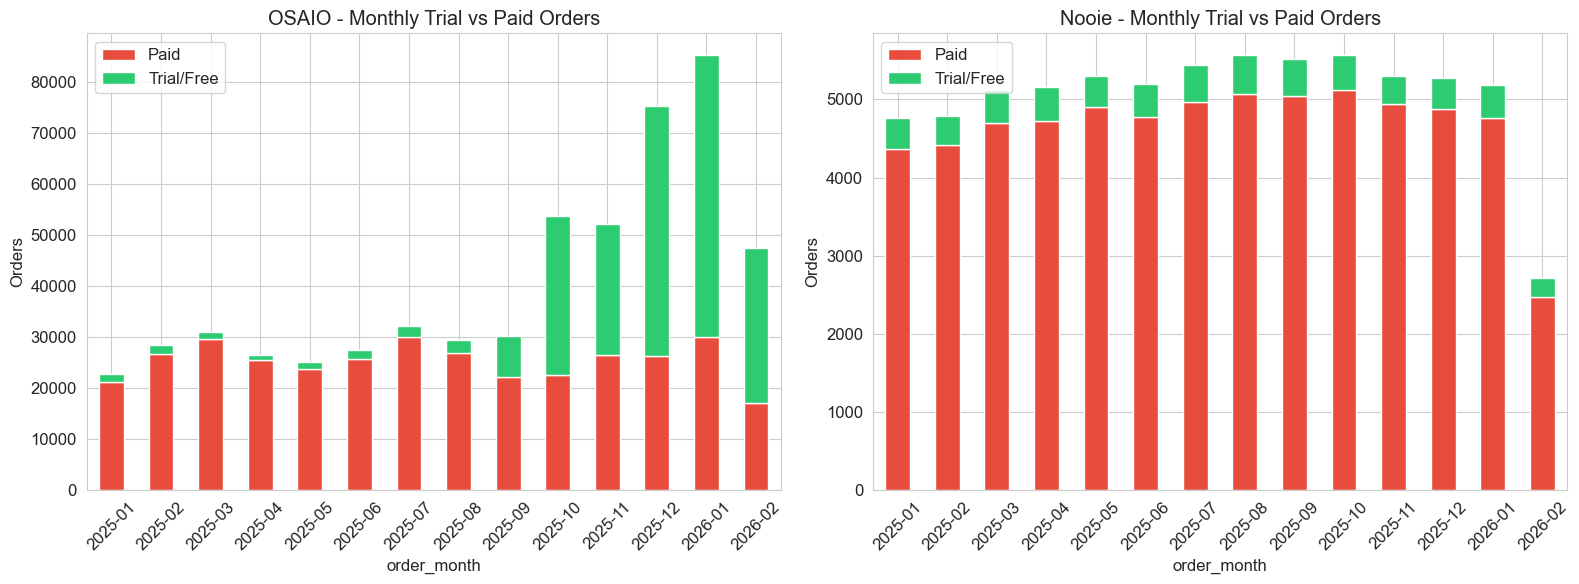

In [11]:
# 试用 vs 付费 占比
trial_summary = df_all.groupby(['brand', 'order_type']).size().unstack(fill_value=0)
trial_summary['Total'] = trial_summary.sum(axis=1)
for col in ['Trial/Free', 'Paid']:
    if col in trial_summary.columns:
        trial_summary[f'{col}_%'] = (trial_summary[col] / trial_summary['Total'] * 100).round(1)

print('=== 试用 vs 付费 汇总 ===')
display(trial_summary)

# 月度试用 vs 付费趋势
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, brand in enumerate(['OSAIO', 'Nooie']):
    brand_df = df_all[df_all['brand'] == brand]
    monthly_type = brand_df.groupby(['order_month', 'order_type']).size().unstack(fill_value=0)
    monthly_type.index = monthly_type.index.to_timestamp()
    
    monthly_type.plot(kind='bar', stacked=True, ax=axes[i], 
                       color=['#e74c3c', '#2ecc71'])
    axes[i].set_title(f'{brand} - Monthly Trial vs Paid Orders')
    axes[i].set_ylabel('Orders')
    axes[i].set_xticklabels([d.strftime('%Y-%m') for d in monthly_type.index], rotation=45)
    axes[i].legend()

plt.tight_layout()
plt.savefig('../reports/order_trial_vs_paid.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. 试用转化率分析

In [12]:
# 试用转化率: 试用用户中有多少后续购买了付费订阅
conversion = {}

for brand in ['OSAIO', 'Nooie']:
    brand_df = df_all[df_all['brand'] == brand]
    
    # 试用用户
    trial_users = set(brand_df[brand_df['is_trial']]['uid'].unique())
    
    # 付费用户
    paid_users = set(brand_df[~brand_df['is_trial']]['uid'].unique())
    
    # 既试用又付费的用户
    converted_users = trial_users & paid_users
    
    conv_rate = len(converted_users) / len(trial_users) * 100 if trial_users else 0
    
    conversion[brand] = {
        'trial_users': len(trial_users),
        'paid_users': len(paid_users),
        'converted_users': len(converted_users),
        'conversion_rate_%': round(conv_rate, 2)
    }

conv_df = pd.DataFrame(conversion).T
print('=== 试用转化率 ===')
display(conv_df)

=== 试用转化率 ===


,trial_users,paid_users,converted_users,conversion_rate_%
OSAIO,"23,644.00","31,709.00","15,151.00",64.08
Nooie,"5,522.00","9,663.00","3,921.00",71.01


In [13]:
# 月度试用转化趋势
# 逻辑: 某月试用的用户，后续任意月份是否有付费订单
monthly_conversion = []

for brand in ['OSAIO', 'Nooie']:
    brand_df = df_all[df_all['brand'] == brand]
    trial_df = brand_df[brand_df['is_trial']].copy()
    paid_df = brand_df[~brand_df['is_trial']].copy()
    
    # 每个试用用户的首次试用月份
    trial_first = trial_df.groupby('uid')['order_date'].min().reset_index()
    trial_first['trial_month'] = trial_first['order_date'].dt.to_period('M')
    
    # 每个付费用户的首次付费时间
    paid_first = paid_df.groupby('uid')['order_date'].min().reset_index()
    paid_first.columns = ['uid', 'first_paid_date']
    
    # 合并
    merged = trial_first.merge(paid_first, on='uid', how='left')
    # 转化 = 首次付费时间 > 首次试用时间
    merged['converted'] = merged['first_paid_date'].notna() & (merged['first_paid_date'] > merged['order_date'])
    
    by_month = merged.groupby('trial_month').agg(
        trial_users=('uid', 'count'),
        converted=('converted', 'sum')
    )
    by_month['conversion_rate_%'] = (by_month['converted'] / by_month['trial_users'] * 100).round(2)
    by_month['brand'] = brand
    monthly_conversion.append(by_month.reset_index())

conv_monthly_df = pd.concat(monthly_conversion, ignore_index=True)
print('=== 月度试用转化率 ===')
display(conv_monthly_df)

# 注意: 最近几个月转化率偏低是因为用户还没有足够时间转化
print('\n注: 最近月份转化率偏低是因为观察窗口不足')

=== 月度试用转化率 ===


,trial_month,trial_users,converted,conversion_rate_%,brand
0,2025-01,1452,1171,80.65,OSAIO
1,2025-02,1724,1214,70.42,OSAIO
2,2025-03,1243,907,72.97,OSAIO
3,2025-04,969,714,73.68,OSAIO
4,2025-05,1060,771,72.74,OSAIO
5,2025-06,1183,908,76.75,OSAIO
6,2025-07,1686,1306,77.46,OSAIO
7,2025-08,1852,1250,67.49,OSAIO
8,2025-09,1821,1209,66.39,OSAIO
9,2025-10,1817,1027,56.52,OSAIO



注: 最近月份转化率偏低是因为观察窗口不足


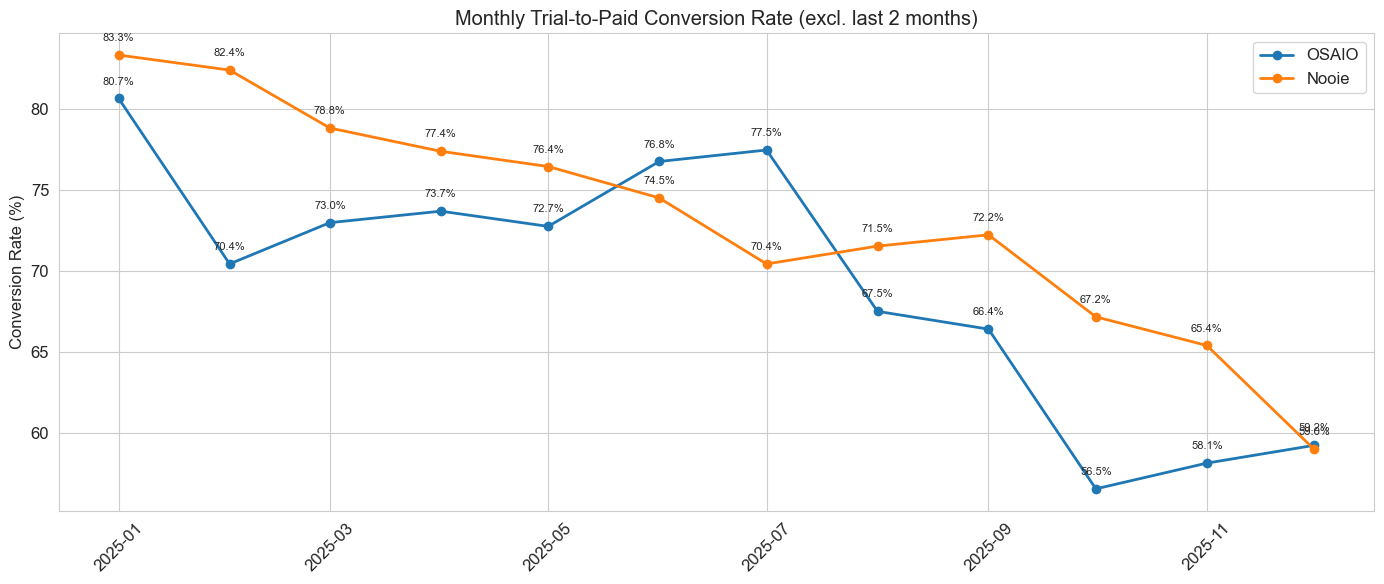

In [14]:
# 试用转化率可视化
fig, ax = plt.subplots(figsize=(14, 6))

for brand in ['OSAIO', 'Nooie']:
    brand_conv = conv_monthly_df[conv_monthly_df['brand'] == brand]
    # 排除最近2个月 (观察窗口不足)
    brand_conv = brand_conv[brand_conv['trial_month'] < CURRENT_MONTH - 1]
    if len(brand_conv) > 0:
        x = brand_conv['trial_month'].dt.to_timestamp()
        ax.plot(x, brand_conv['conversion_rate_%'], marker='o', 
                linewidth=2, markersize=6, label=brand)
        for _, row in brand_conv.iterrows():
            ax.annotate(f"{row['conversion_rate_%']:.1f}%",
                       (row['trial_month'].to_timestamp(), row['conversion_rate_%']),
                       textcoords='offset points', xytext=(0, 10),
                       ha='center', fontsize=8)

ax.set_title('Monthly Trial-to-Paid Conversion Rate (excl. last 2 months)')
ax.set_ylabel('Conversion Rate (%)')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/order_trial_conversion.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. 收入分析

In [15]:
# 付费订单: amount > 0 (status=1 已在数据同步时过滤)
df_paid = df_all[df_all['amount'] > 0].copy()

# 月度净营收
monthly_revenue = df_paid.groupby(['order_month', 'brand']).agg(
    net_revenue_cny=('net_revenue_cny', 'sum'),
    order_count=('order_int_id', 'count'),
    avg_net_revenue=('net_revenue_cny', 'mean')
).round(2)

print('=== 月度净营收 (CNY, 扣手续费) ===')
display(monthly_revenue)

=== 月度收入统计 (CNY) ===


total_revenue_cny  net_revenue_cny  order_count  \
order_month brand                                                    
2025-01     Nooie         216,719.64       193,805.88         4354   
            OSAIO         726,733.38       661,148.31        17529   
2025-02     Nooie         216,628.46       193,577.48         4395   
            OSAIO         697,509.86       642,858.31        16613   
2025-03     Nooie         219,222.39       195,380.32         4684   
            OSAIO         775,302.36       714,674.33        17846   
2025-04     Nooie         233,580.93       208,943.48         4693   
            OSAIO         748,630.62       690,073.38        17023   
2025-05     Nooie         248,919.23       223,086.97         4879   
            OSAIO         763,591.29       703,582.55        17085   
2025-06     Nooie         229,500.21       205,073.39         4744   
            OSAIO         744,608.63       685,856.29        16447   
2025-07     Nooie         262,315.81       235,697.91         4946   
            OSAIO         806,201.39       742,195.82        17480   
2025-08     Nooie         273,420.46       246,070.94         5060   
            OSAIO         981,331.44       907,398.37        18230   
2025-09     Nooie         259,194.04       232,665.69         5020   
            OSAIO       1,043,230.10       966,404.29        17766   
2025-10     Nooie         294,565.05       266,089.41         5108   
            OSAIO         997,301.91       923,125.65        17568   
2025-11     Nooie         288,344.26       260,874.32         4915   
            OSAIO         979,293.01       907,087.13        16830   
2025-12     Nooie         294,931.03       267,126.44         4861   
            OSAIO       1,055,665.01       978,901.79        17436   
2026-01     Nooie         284,916.20       258,031.87         4746   
            OSAIO       1,073,430.24       995,125.89        17567   
2026-02     Nooie         148,061.83       134,152.90         2459   
            OSAIO         554,502.05       513,704.19         9151   

                   avg_order_value  
order_month brand                   
2025-01     Nooie            49.77  
            OSAIO            41.46  
2025-02     Nooie            49.29  
            OSAIO            41.99  
2025-03     Nooie            46.80  
            OSAIO            43.44  
2025-04     Nooie            49.77  
            OSAIO            43.98  
2025-05     Nooie            51.02  
            OSAIO            44.69  
2025-06     Nooie            48.38  
            OSAIO            45.27  
2025-07     Nooie            53.04  
            OSAIO            46.12  
2025-08     Nooie            54.04  
            OSAIO            53.83  
2025-09     Nooie            51.63  
            OSAIO            58.72  
2025-10     Nooie            57.67  
            OSAIO            56.77  
2025-11     Nooie            58.67  
            OSAIO            58.19  
2025-12     Nooie            60.67  
            OSAIO            60.55  
2026-01     Nooie            60.03  
            OSAIO            61.10  
2026-02     Nooie            60.21  
            OSAIO            60.59

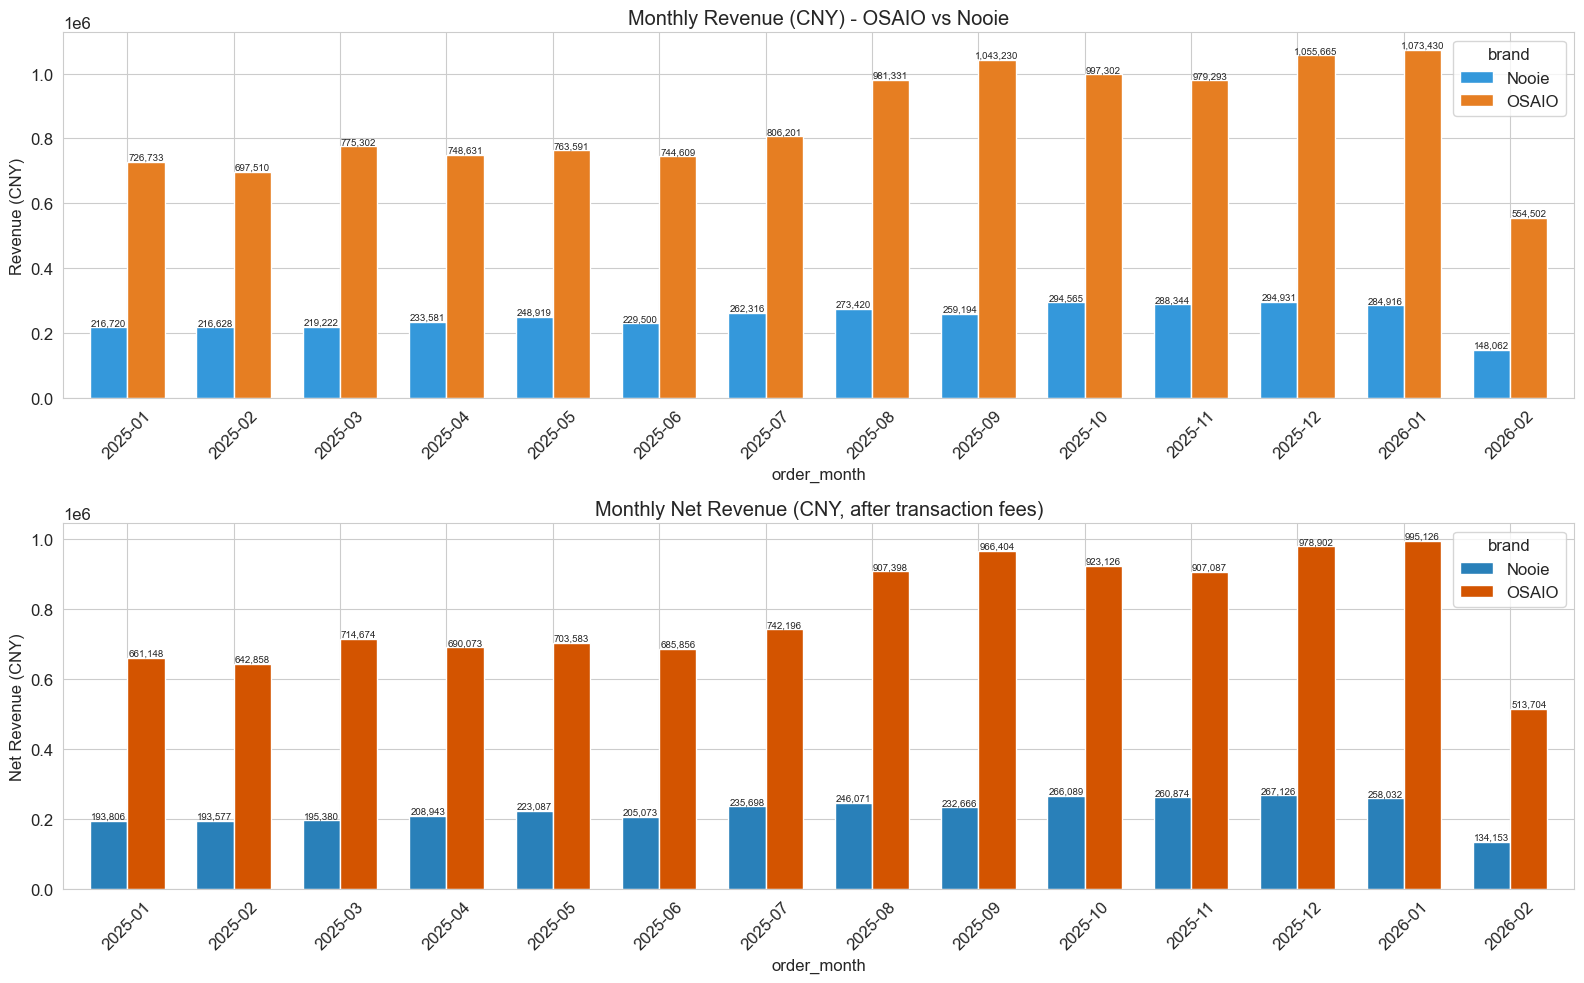

In [16]:
# 月度净营收趋势图
fig, ax = plt.subplots(figsize=(16, 6))

rev_pivot = df_paid.groupby(['order_month', 'brand'])['net_revenue_cny'].sum().unstack(fill_value=0)
rev_pivot.index = rev_pivot.index.to_timestamp()
rev_pivot.plot(kind='bar', ax=ax, width=0.7, color=['#3498db', '#e67e22'])
ax.set_title('Monthly Net Revenue (CNY, after transaction fees)')
ax.set_ylabel('Net Revenue (CNY)')
ax.set_xticklabels([d.strftime('%Y-%m') for d in rev_pivot.index], rotation=45)
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', fontsize=7, rotation=0)

plt.tight_layout()
plt.savefig('../reports/order_revenue_trend.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# ARPU (Average Net Revenue Per User)
arpu = {}
for brand in ['OSAIO', 'Nooie']:
    brand_paid = df_paid[df_paid['brand'] == brand]
    total_rev = brand_paid['net_revenue_cny'].sum()
    unique_users = brand_paid['uid'].nunique()
    arpu[brand] = {
        'net_revenue_cny': round(total_rev, 2),
        'paying_users': unique_users,
        'ARPU_cny': round(total_rev / unique_users, 2) if unique_users > 0 else 0
    }

arpu_df = pd.DataFrame(arpu).T
print('=== ARPU (付费用户平均净收入) ===')
display(arpu_df)

# 月度 ARPU
monthly_arpu = df_paid.groupby(['order_month', 'brand']).agg(
    revenue=('net_revenue_cny', 'sum'),
    users=('uid', 'nunique')
)
monthly_arpu['ARPU'] = (monthly_arpu['revenue'] / monthly_arpu['users']).round(2)
print('\n=== 月度 ARPU ===')
display(monthly_arpu)

=== ARPU (付费用户平均收入) ===


,total_revenue_cny,paying_users,ARPU_cny
OSAIO,"11,947,331.29","31,568.00",378.46
Nooie,"3,470,319.54","9,606.00",361.27



=== 月度 ARPU ===


revenue  users  ARPU
order_month brand                          
2025-01     Nooie   216,719.64   3527 61.45
            OSAIO   726,733.38  13119 55.40
2025-02     Nooie   216,628.46   3546 61.09
            OSAIO   697,509.86  12575 55.47
2025-03     Nooie   219,222.39   3700 59.25
            OSAIO   775,302.36  13187 58.79
2025-04     Nooie   233,580.93   3814 61.24
            OSAIO   748,630.62  12747 58.73
2025-05     Nooie   248,919.23   3935 63.26
            OSAIO   763,591.29  12656 60.33
2025-06     Nooie   229,500.21   3882 59.12
            OSAIO   744,608.63  12552 59.32
2025-07     Nooie   262,315.81   4018 65.29
            OSAIO   806,201.39  12988 62.07
2025-08     Nooie   273,420.46   4156 65.79
            OSAIO   981,331.44  13650 71.89
2025-09     Nooie   259,194.04   4126 62.82
            OSAIO 1,043,230.10  13550 76.99
2025-10     Nooie   294,565.05   4169 70.66
            OSAIO   997,301.91  13185 75.64
2025-11     Nooie   288,344.26   4068 70.88
            OSAIO   979,293.01  12810 76.45
2025-12     Nooie   294,931.03   3961 74.46
            OSAIO 1,055,665.01  13011 81.14
2026-01     Nooie   284,916.20   3906 72.94
            OSAIO 1,073,430.24  13239 81.08
2026-02     Nooie   148,061.83   2126 69.64
            OSAIO   554,502.05   7611 72.86

## 7. 币种分布

=== 币种分布 ===


order_count  total_amount  total_amount_cny
brand currency                                             
Nooie CAD                18        232.26          1,199.43
      EUR             18966    148,864.65      1,201,631.04
      GBP             45549    239,315.50      2,249,559.73
      USD               331      2,518.29         17,929.34
OSAIO CAD                60        554.22          2,866.00
      EUR             78403    538,914.91      4,360,153.97
      GBP            155442    803,556.41      7,551,182.35
      USD               666      4,660.36         33,128.97

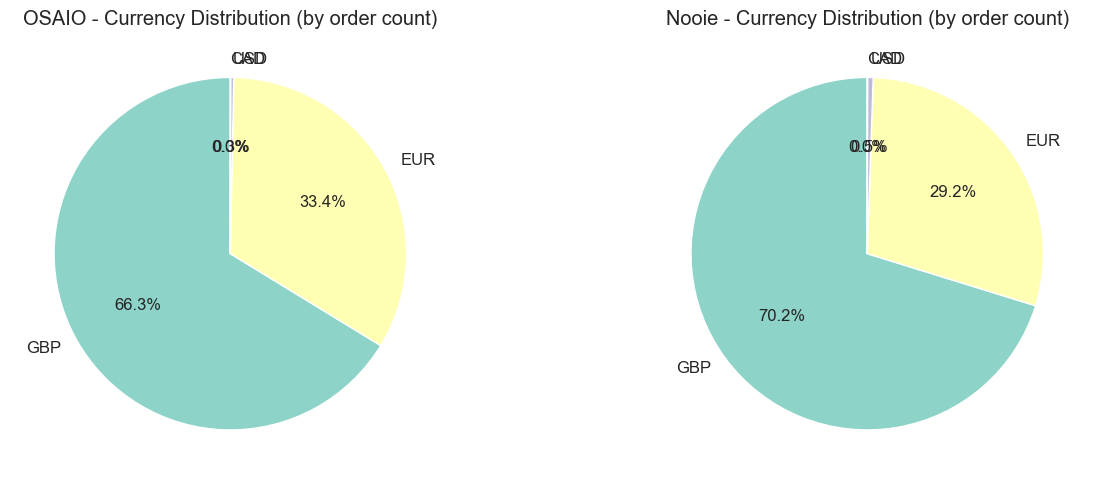

In [18]:
# 币种分布
currency_dist = df_paid.groupby(['brand', 'currency']).agg(
    order_count=('order_int_id', 'count'),
    total_amount=('amount', 'sum'),
    net_revenue_cny=('net_revenue_cny', 'sum')
).round(2)

print('=== 币种分布 ===')
display(currency_dist)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, brand in enumerate(['OSAIO', 'Nooie']):
    brand_curr = df_paid[df_paid['brand'] == brand]['currency'].value_counts()
    brand_curr = brand_curr[brand_curr > 0]
    colors = sns.color_palette('Set3', len(brand_curr))
    brand_curr.plot(kind='pie', ax=axes[i], autopct='%1.1f%%', 
                    startangle=90, colors=colors)
    axes[i].set_title(f'{brand} - Currency Distribution (by order count)')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.savefig('../reports/order_currency_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. 订阅周期偏好趋势

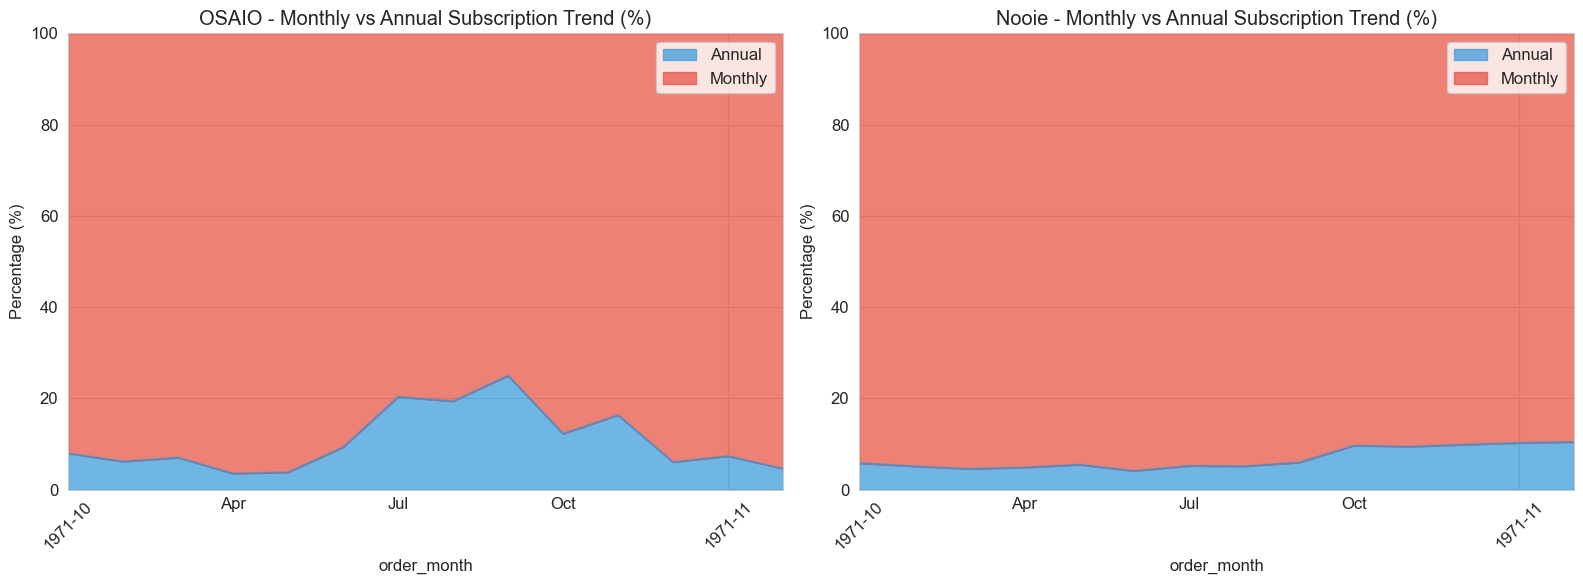

In [19]:
# 月度订阅周期占比趋势
# 只看主要类型: Monthly, Annual, Trial
main_periods = df_all[df_all['sub_period'].isin(['Monthly', 'Annual'])].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, brand in enumerate(['OSAIO', 'Nooie']):
    brand_df = main_periods[main_periods['brand'] == brand]
    monthly_period = brand_df.groupby(['order_month', 'sub_period']).size().unstack(fill_value=0)
    
    # 计算占比
    monthly_period_pct = monthly_period.div(monthly_period.sum(axis=1), axis=0) * 100
    monthly_period_pct.index = monthly_period_pct.index.to_timestamp()
    
    monthly_period_pct.plot(kind='area', stacked=True, ax=axes[i], 
                            alpha=0.7, color=['#3498db', '#e74c3c'])
    axes[i].set_title(f'{brand} - Monthly vs Annual Subscription Trend (%)')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_ylim(0, 100)
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.savefig('../reports/order_subscription_preference.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:
# 月/年订阅详细数据
for brand in ['OSAIO', 'Nooie']:
    brand_df = main_periods[main_periods['brand'] == brand]
    monthly_period = brand_df.groupby(['order_month', 'sub_period']).size().unstack(fill_value=0)
    monthly_period['Total'] = monthly_period.sum(axis=1)
    for col in ['Monthly', 'Annual']:
        if col in monthly_period.columns:
            monthly_period[f'{col}_%'] = (monthly_period[col] / monthly_period['Total'] * 100).round(1)
    print(f'\n=== {brand} 月/年订阅趋势 ===')
    display(monthly_period)


=== OSAIO 月/年订阅趋势 ===


sub_period,Annual,Monthly,Total,Monthly_%,Annual_%
order_month,,,,,
2025-01,983,11368,12351,92.00,8.00
2025-02,972,14808,15780,93.80,6.20
2025-03,1021,13535,14556,93.00,7.00
2025-04,560,15381,15941,96.50,3.50
2025-05,568,14366,14934,96.20,3.80
2025-06,1663,16234,17897,90.70,9.30
2025-07,3904,15300,19204,79.70,20.30
2025-08,3321,13818,17139,80.60,19.40
2025-09,5075,15248,20323,75.00,25.00



=== Nooie 月/年订阅趋势 ===


sub_period,Annual,Monthly,Total,Monthly_%,Annual_%
order_month,,,,,
2025-01,274,4449,4723,94.20,5.80
2025-02,243,4499,4742,94.90,5.10
2025-03,231,4855,5086,95.50,4.50
2025-04,249,4882,5131,95.10,4.90
2025-05,288,4976,5264,94.50,5.50
2025-06,212,4951,5163,95.90,4.10
2025-07,282,5136,5418,94.80,5.20
2025-08,284,5255,5539,94.90,5.10
2025-09,326,5160,5486,94.10,5.90


## 9. 多设备订阅分析 (2026+)

=== 多设备订阅 (support_dev_num > 1, 2026+) ===
总数: 188 订单


,,order_count,unique_users,avg_amount_cny
brand,support_dev_num,,,
OSAIO,5.00,188,40,19.99


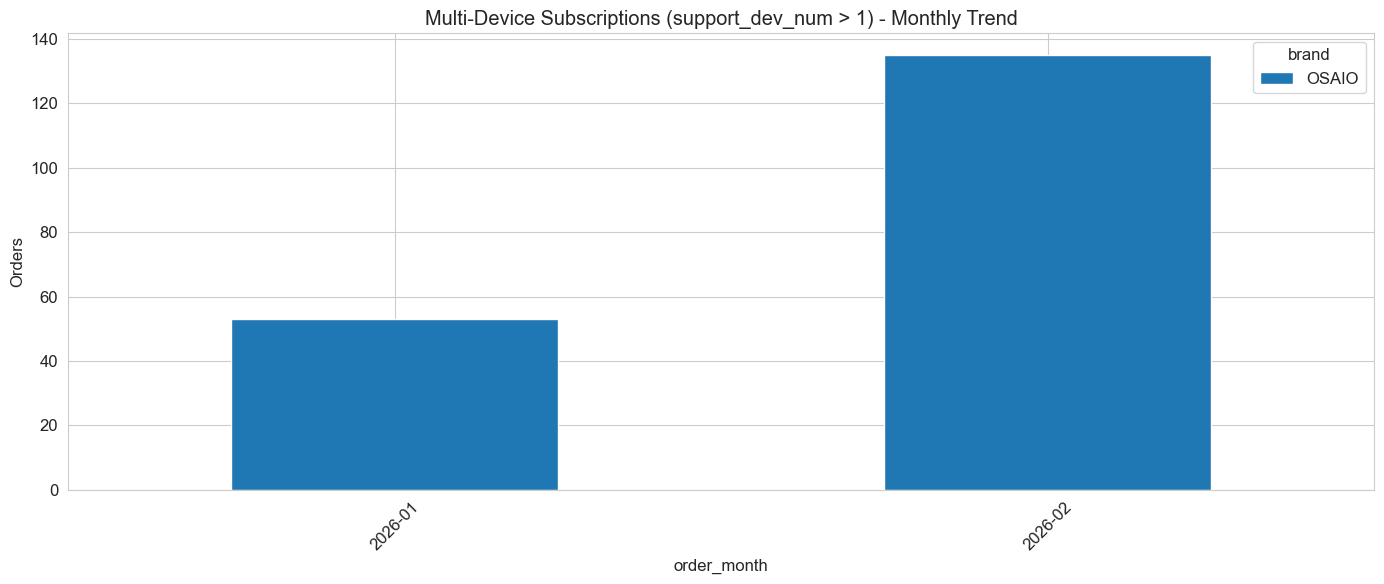


=== support_dev_num 分布 (全量) ===


support_dev_num,-1.00,0.00,1.00,5.00
brand,,,,
Nooie,0,70481,0,0
OSAIO,556,14909,551126,188


In [21]:
# support_dev_num > 1 的订阅
ts_2026 = 1735689600 + 365 * 86400  # 约2026-01-01

multi_dev = df_all[
    (df_all['support_dev_num'].notna()) & 
    (df_all['support_dev_num'] > 1) &
    (df_all['pay_time'] >= ts_2026)
].copy()

if len(multi_dev) > 0:
    print(f'=== 多设备订阅 (support_dev_num > 1, 2026+) ===')
    print(f'总数: {len(multi_dev):,} 订单')
    
    multi_dev_summary = multi_dev.groupby(['brand', 'support_dev_num']).agg(
        order_count=('order_int_id', 'count'),
        unique_users=('uid', 'nunique'),
        avg_net_revenue=('net_revenue_cny', 'mean')
    ).round(2)
    display(multi_dev_summary)
    
    # 月度趋势
    multi_monthly = multi_dev.groupby(['order_month', 'brand']).size().unstack(fill_value=0)
    if len(multi_monthly) > 1:
        multi_monthly.index = multi_monthly.index.to_timestamp()
        fig, ax = plt.subplots(figsize=(14, 6))
        multi_monthly.plot(kind='bar', ax=ax)
        ax.set_title('Multi-Device Subscriptions (support_dev_num > 1) - Monthly Trend')
        ax.set_ylabel('Orders')
        ax.set_xticklabels([d.strftime('%Y-%m') for d in multi_monthly.index], rotation=45)
        plt.tight_layout()
        plt.savefig('../reports/order_multi_device.png', dpi=150, bbox_inches='tight')
        plt.show()
else:
    print('2026年后无多设备订阅数据 (support_dev_num > 1)')

# support_dev_num 分布总览
print('\n=== support_dev_num 分布 (全量) ===')
display(df_all.groupby('brand')['support_dev_num'].value_counts().unstack(fill_value=0))

## 10. 云服务时长分析

=== 云服务时长统计 ===


,count,mean,std,min,25%,50%,75%,max
brand,,,,,,,,
Nooie,"67,742.00",46.30,74.10,1.00,30.00,31.00,31.00,731.00
OSAIO,"246,415.00",58.30,286.90,1.00,30.00,30.00,31.00,"4,616.00"


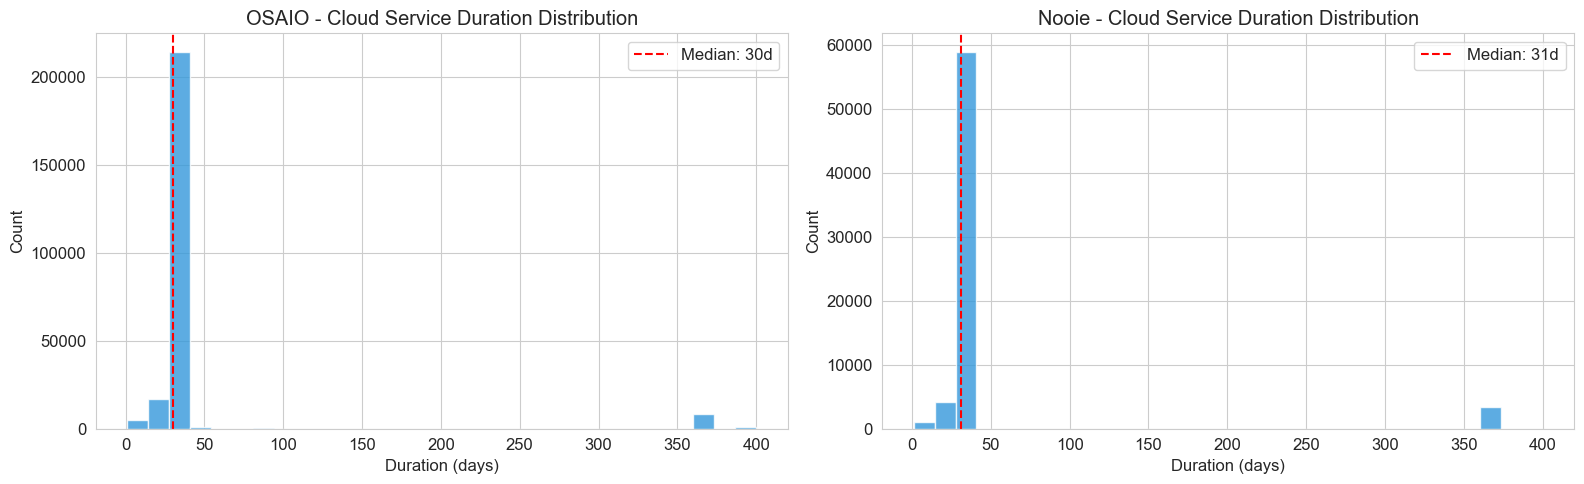


=== cloud_info.status 分布 ===


cloud_status,0,1
brand,,
Nooie,25983,42444
OSAIO,101166,147753


In [22]:
# cloud_info 时长分析
valid_cloud = df_cloud_all[
    (df_cloud_all['cloud_duration_days'].notna()) & 
    (df_cloud_all['cloud_duration_days'] > 0)
].copy()

if len(valid_cloud) > 0:
    print('=== 云服务时长统计 ===')
    cloud_stats = valid_cloud.groupby('brand')['cloud_duration_days'].describe().round(1)
    display(cloud_stats)
    
    # 时长分布直方图
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    for i, brand in enumerate(['OSAIO', 'Nooie']):
        brand_cloud = valid_cloud[valid_cloud['brand'] == brand]
        if len(brand_cloud) > 0:
            axes[i].hist(brand_cloud['cloud_duration_days'].clip(upper=400), 
                        bins=30, edgecolor='white', alpha=0.8, color='#3498db')
            axes[i].set_title(f'{brand} - Cloud Service Duration Distribution')
            axes[i].set_xlabel('Duration (days)')
            axes[i].set_ylabel('Count')
            axes[i].axvline(brand_cloud['cloud_duration_days'].median(), 
                           color='red', linestyle='--', label=f"Median: {brand_cloud['cloud_duration_days'].median():.0f}d")
            axes[i].legend()
    
    plt.tight_layout()
    plt.savefig('../reports/order_cloud_duration.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # cloud_status 分布
    print('\n=== cloud_info.status 分布 ===')
    display(df_cloud_all.groupby(['brand', 'cloud_status']).size().unstack(fill_value=0))
else:
    print('无有效云服务时长数据')

## 11. 设备订阅覆盖率

In [23]:
# 有活跃订阅的设备数 vs 总设备数
# 数据来自 sync 脚本预计算的 device_stats 表
coverage = {}
for _, row in df_device_stats.iterrows():
    brand = row['brand']
    total_dev = int(row['total_devices'])
    act_dev = int(row['active_devices_30d'])
    sub_dev = int(row['devices_with_subscription'])
    
    coverage[brand] = {
        'total_devices_2025': total_dev,
        'active_devices_30d': act_dev,
        'devices_with_subscription': sub_dev,
        'coverage_vs_total_%': round(sub_dev / total_dev * 100, 2) if total_dev > 0 else 0,
        'coverage_vs_active_%': round(sub_dev / act_dev * 100, 2) if act_dev > 0 else 0
    }

coverage_df = pd.DataFrame(coverage).T
print('=== 设备订阅覆盖率 ===')
display(coverage_df)

=== 设备订阅覆盖率 ===


,total_devices_2025,active_devices_30d,devices_with_subscription,coverage_vs_total_%,coverage_vs_active_%
OSAIO,"197,193.00","140,676.00","25,236.00",12.80,17.94
Nooie,"30,965.00","20,224.00","7,374.00",23.81,36.46


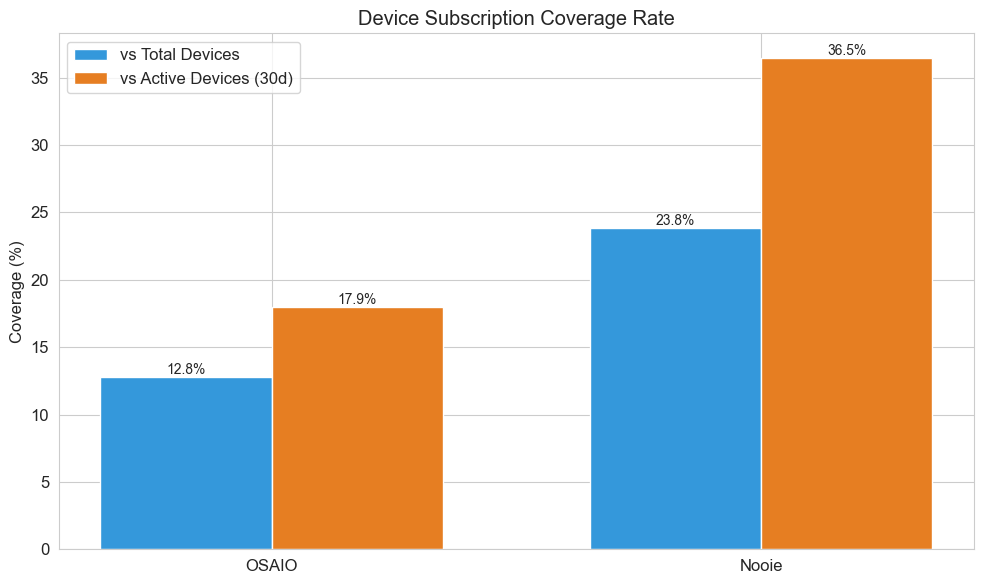

In [24]:
# 设备订阅覆盖率可视化
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(coverage_df))
width = 0.35

bars1 = ax.bar(x - width/2, coverage_df['coverage_vs_total_%'], width, 
               label='vs Total Devices', color='#3498db')
bars2 = ax.bar(x + width/2, coverage_df['coverage_vs_active_%'], width, 
               label='vs Active Devices (30d)', color='#e67e22')

ax.set_title('Device Subscription Coverage Rate')
ax.set_ylabel('Coverage (%)')
ax.set_xticks(x)
ax.set_xticklabels(coverage_df.index)
ax.legend()
ax.bar_label(bars1, fmt='%.1f%%', fontsize=10)
ax.bar_label(bars2, fmt='%.1f%%', fontsize=10)

plt.tight_layout()
plt.savefig('../reports/order_device_coverage.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. 品牌对比汇总

In [25]:
# 综合对比表
brand_summary = {}

for brand in ['OSAIO', 'Nooie']:
    brand_paid = df_paid[df_paid['brand'] == brand]
    
    brand_summary[brand] = {
        'Paid Orders': len(brand_paid),
        'Unique Paying Users': brand_paid['uid'].nunique(),
        'Net Revenue (CNY)': round(brand_paid['net_revenue_cny'].sum(), 2),
        'ARPU (CNY)': round(brand_paid['net_revenue_cny'].sum() / brand_paid['uid'].nunique(), 2) if brand_paid['uid'].nunique() > 0 else 0,
        'Avg Order Net Value (CNY)': round(brand_paid['net_revenue_cny'].mean(), 2) if len(brand_paid) > 0 else 0,
        'Sub Coverage (Total) %': coverage[brand]['coverage_vs_total_%'],
        'Sub Coverage (Active) %': coverage[brand]['coverage_vs_active_%'],
    }

summary_df = pd.DataFrame(brand_summary)
print('=== 品牌综合对比 ===')
display(summary_df)

=== 品牌综合对比 ===


,OSAIO,Nooie
Total Orders,"566,780.00","70,891.00"
Paid Orders,"234,571.00","64,864.00"
Trial Orders,"213,260.00","5,753.00"
Trial %,37.60,8.10
Unique Paying Users,"31,568.00","9,606.00"
Total Revenue (CNY),"11,947,331.29","3,470,319.54"
Net Revenue (CNY),"11,032,136.30","3,120,577.00"
ARPU (CNY),378.46,361.27
Avg Order Value (CNY),50.93,53.50
Trial Conversion %,64.08,71.01


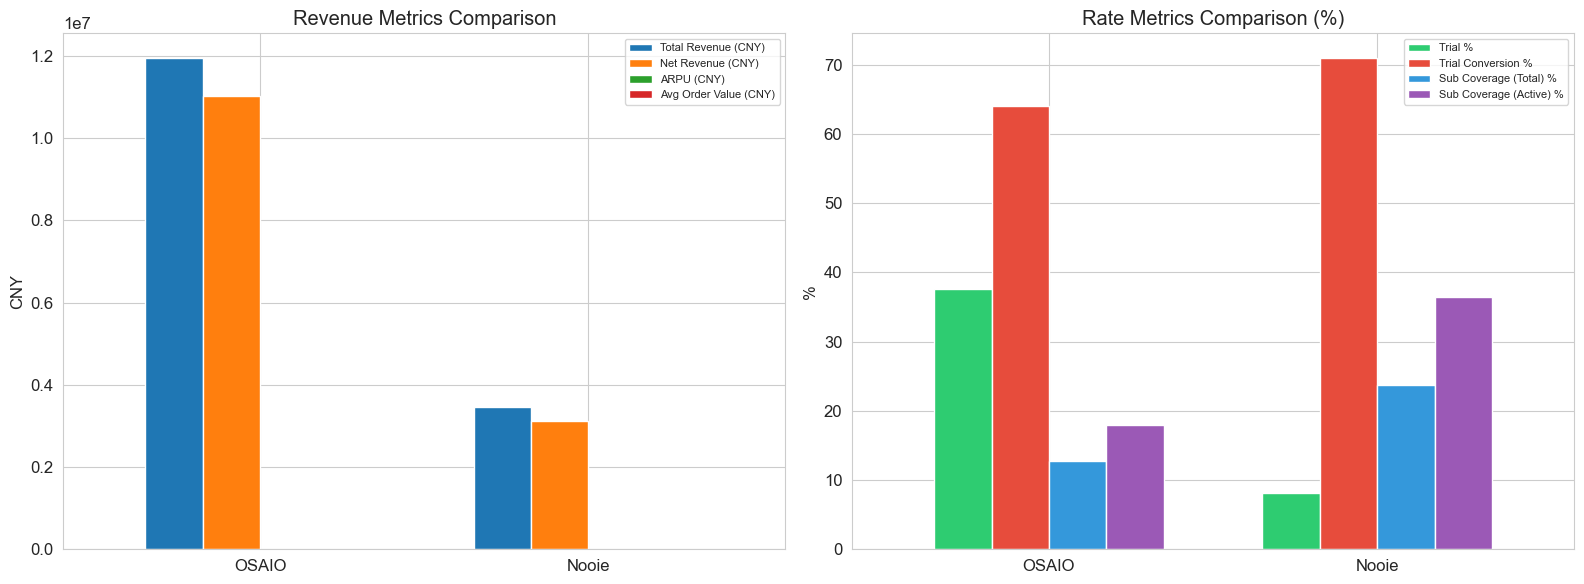

In [26]:
# 品牌对比图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 收入指标
rev_metrics = ['Net Revenue (CNY)', 'ARPU (CNY)', 'Avg Order Net Value (CNY)']
rev_data = summary_df.loc[rev_metrics]
rev_data.T.plot(kind='bar', ax=axes[0], width=0.7)
axes[0].set_title('Revenue Metrics Comparison')
axes[0].set_ylabel('CNY')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(fontsize=8, loc='upper right')

# 覆盖率
rate_metrics = ['Sub Coverage (Total) %', 'Sub Coverage (Active) %']
rate_data = summary_df.loc[rate_metrics]
rate_data.T.plot(kind='bar', ax=axes[1], width=0.7, color=['#3498db', '#9b59b6'])
axes[1].set_title('Device Subscription Coverage (%)')
axes[1].set_ylabel('%')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(fontsize=8, loc='upper right')

plt.tight_layout()
plt.savefig('../reports/order_brand_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. 生成分析报告

In [27]:
# 生成 Markdown 报告
report_time = datetime.now().strftime('%Y-%m-%d %H:%M')

report = f"""# EU区订单与订阅分析报告 (2025年至今)

**生成时间**: {report_time}  
**数据范围**: 2025-01-01 至今  
**数据来源**: 本地 SQLite (scripts/sync_order_data.py 同步)

---

## 1. 概览

| 指标 | OSAIO | Nooie |
|------|-------|-------|
| 付费订单数 | {brand_summary['OSAIO']['Paid Orders']:,} | {brand_summary['Nooie']['Paid Orders']:,} |
| 付费用户数 | {brand_summary['OSAIO']['Unique Paying Users']:,} | {brand_summary['Nooie']['Unique Paying Users']:,} |
| 净收入 (CNY) | {brand_summary['OSAIO']['Net Revenue (CNY)']:,.2f} | {brand_summary['Nooie']['Net Revenue (CNY)']:,.2f} |
| ARPU (CNY) | {brand_summary['OSAIO']['ARPU (CNY)']:,.2f} | {brand_summary['Nooie']['ARPU (CNY)']:,.2f} |
| 平均客单净值 (CNY) | {brand_summary['OSAIO']['Avg Order Net Value (CNY)']:,.2f} | {brand_summary['Nooie']['Avg Order Net Value (CNY)']:,.2f} |
| 设备订阅覆盖率(总) | {brand_summary['OSAIO']['Sub Coverage (Total) %']}% | {brand_summary['Nooie']['Sub Coverage (Total) %']}% |
| 设备订阅覆盖率(活跃) | {brand_summary['OSAIO']['Sub Coverage (Active) %']}% | {brand_summary['Nooie']['Sub Coverage (Active) %']}% |

## 图表

![净营收趋势](order_revenue_trend.png)
![订阅周期分布](order_subscription_period.png)
![币种分布](order_currency_distribution.png)
![订阅周期偏好](order_subscription_preference.png)
![云服务时长](order_cloud_duration.png)
![设备订阅覆盖率](order_device_coverage.png)
![品牌对比](order_brand_comparison.png)

---

**分析说明**:
- 付费订单: status=1 且 amount > 0
- 净营收 = amount_cny - transaction_fee_cny
- 首期/续费判定: 基于每个 subscribe_id 的全局最早 pay_time（含2025年前历史）
"""

with open('../reports/03_order_analysis_report.md', 'w') as f:
    f.write(report)

print('报告已保存: reports/03_order_analysis_report.md')

报告已保存: reports/03_order_analysis_report.md


In [28]:
# 关闭连接
db.close()
print('SQLite 连接已关闭')

SQLite 连接已关闭
